# Compyter Vision

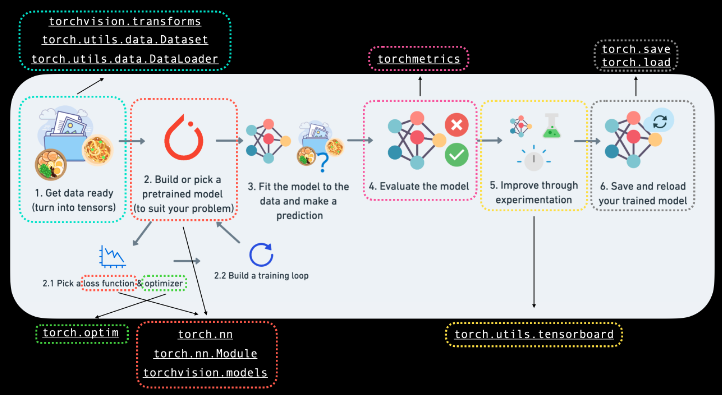

## [torchvision Module](https://pytorch.org/vision/stable/index.html)

[torchvision.datasets](https://pytorch.org/vision/stable/datasets.html)
> many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more.
  - [making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets)

[torchvision.models](https://pytorch.org/vision/stable/models.html)
> well-performing and commonly used computer vision model architectures implemented in PyTorch

[torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
> Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here

[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#module-torch.utils.data)
> Creates a Python iteralbe over a dataset

# Import Module

In [1]:
# Import PyTorch
import torch
from torch import nn

from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device: {device}')

PyTorch version: 2.1.0+cpu
torchvision version: 0.16.0+cpu
device: cpu


In [2]:
import torchinfo

In [3]:
import os, random
import numpy as np
import pandas as pd

# SEED = 42

def reset_seeds(seed=42):
    # 파이썬
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    # numpy & pandas -> 머신러닝
    np.random.seed(seed)
    # pytorch -> 딥러닝
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

reset_seeds()

In [4]:
def eval_model(
    model: torch.nn.Module, # 딥러닝 모델
    data_loader: torch.utils.data.DataLoader, # 데이터 로더(배치)
    loss_fn: torch.nn.Module, # 로스함수
    accuracy_fn, # 평가함수
    device: torch.device = device # 디바이스(cpu, gpu)
):

    loss, acc = 0, 0 # test loss / test acc
    model.eval() # 평가 모드 전화
    with torch.inference_mode(): # 모델의 파라미터를 고정!!!!
        # 테스트 데이터 로드를 통해서
        # 배치 단위로 features, targets 뽑아낸다...
        # X -> 배치 단위로 모인 features들....
        # y -> 배치 단위로 모인 targets....
        for X, y in data_loader:
            # 모델이 적용된 device에 feature, target 적용....
            X, y = X.to(device), y.to(device)
            # 모델이 feature를 이용하여 pred(예측)....
            y_pred = model(X)
            # y_pred(예측)과 y(실제)의 차이(loss) 구하자....
            # loss_fn(y_pred, y) -> 전체 loss가 아닌, batch loss이다....
            # loss += loss_fn(y_pred, y)
            # -> 전체 데이터(epoch)의 loss ??
            # -> batch loss들의 합이다....
            loss += loss_fn(y_pred, y)
            # 정확도를 계산하자....
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        # loss /= len(data_loader)
        # -> 전체 batch loss 합 / batch의 수
        # -> batch 평균의 loss 값이 -> epoch loss 값 정의할 수 있다.!!!!
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [5]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [6]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [7]:
def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [8]:
def test_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


# Data
> We're going to be using our own custom dataset of pizza, steak and sushi images.

In [9]:
# transforms -> 이미지 전처리를 해주는 모듈.....
# transforms.ToTensor() -> python 숫자를 torch의 tensor 형변환....
# transforms.Normalize()
# -> 데이터를 정규화 했다....
# -> 3차원 컬리이면, 2D 메트릭스 차원이기...
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# pytorch의 dataset class 만들다..!!!!
train_set = torchvision.datasets.CIFAR10(
    root='./data',        # 데이터 저장 위치
    train=True,           # True: train set, False: test set
    download=True,       # 다운로드 여부, (이미 다운받았으면 False로 지정)
    transform=transform   # 데이터 선처리 작업
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # data/pizza_steak_sushi

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


In [12]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [13]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [14]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Visualize an image

Random image path: data\pizza_steak_sushi\test\steak\1302563.jpg
Image class: steak
Image height: 512
Image width: 512


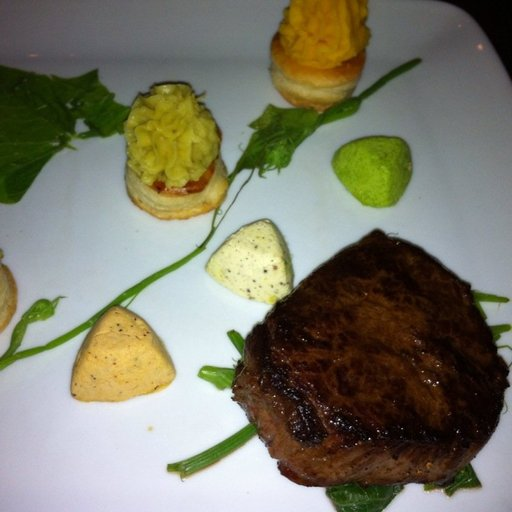

In [71]:
import random
from PIL import Image

# Set seed
random.seed(2) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

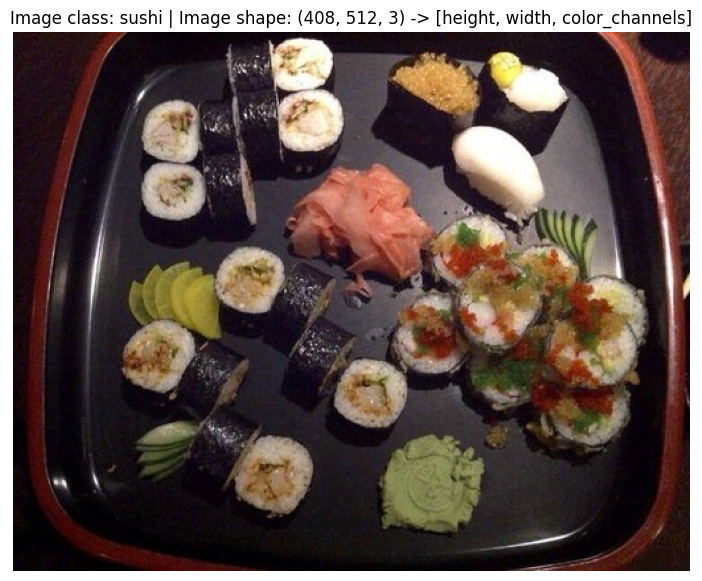

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


# [CNN](https://poloclub.github.io/cnn-explainer/)

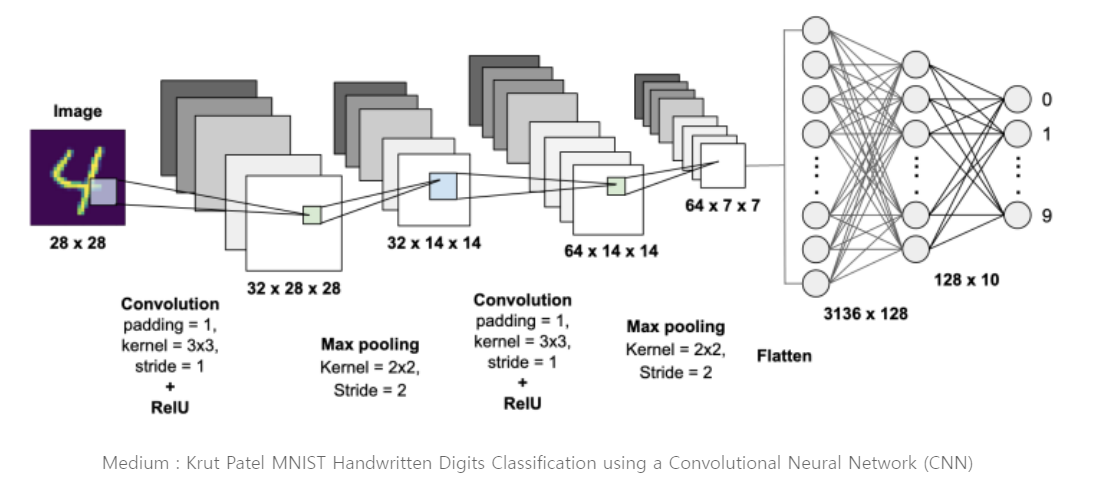

## CNN Layer

### [nn.Conv2d(in_channels, out_channels, kernel_size)](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)  
- `stride`: controls the stride for the cross-correlation, a single number or a tuple.
- `padding`: controls the amount of padding applied to the input.
- `dilation`: controls the spacing between the kernel points


[output tensor size](https://velog.io/@tobigs1516_image/Convolutional-Neural-Networks):

- O: Size(width) of output image
- I: Size(width) of input image
- K: Size(width) of kernels used in the Conv layer
- N: Number of kernels
- S: Stride of the convolution operation
- P: Padding size  

$$
O = { I - K + 2P \over S } + 1
$$

In [17]:
input = torch.randn(1, 1, 28, 28)
m = nn.Conv2d(1, 32, 3, stride=1)
m(input).shape

torch.Size([1, 32, 26, 26])

In [ ]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50, 100)
m(input).shape

torch.Size([20, 33, 24, 49])

In [ ]:
# non-square kernels and unequal stride and with padding and dilation
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
m(input).shape

torch.Size([20, 33, 26, 100])

### [nn.MaxPool2d()](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- `kernel_size`: the size of the window to take a max over
- `stride`: the stride of the window. Default value is `kernel_size`

In [ ]:
# pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
input = torch.randn(20, 16, 50, 32)
m(input).shape

torch.Size([20, 16, 24, 15])

In [ ]:
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
m(input).shape

torch.Size([20, 16, 24, 31])

## Dataset

In [18]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)), # 이미지 크기 변경...
    transforms.ToTensor(), # 데이터를 형변환...
])

In [19]:
# Load and transform data
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=simple_transform)


In [20]:
len(train_data), len(test_data)

(225, 75)

In [21]:
features, target = train_data[0]
features.shape, target

(torch.Size([3, 64, 64]), 0)

## DataLoader

In [22]:
# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, # dataset class
                                     batch_size=BATCH_SIZE, # batch_size
                                     shuffle=True, # shuffle
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2849d65cbd0>,
 <torch.utils.data.dataloader.DataLoader at 0x28499343b50>)

In [23]:
len(train_dataloader) # len(dataloader) = len(dataset) / batch_size

8

In [24]:
features, targets = next(iter(train_dataloader))
# features.shape -> (batch_size, color, height, width)
features.shape, targets.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## CNN Model

In [25]:
# 딥러닝 모델을 만들자!!!
# 1. nn.Module을 상속 받자!!!
# 2. __init__(생성함수)를 만들자...
  # -> 다른 필수 함수를 구현하기 위한 변수를 생성하는 함수...
# 3. forward(학습을 하는 함수)를 만들자...
  # -> 딥러닝 모델의 알고리즘에 맞춰서 코딩을 하자...
  # -> CNN -> Conv2D + Pooling + Linear

class CNNModelV1(nn.Module): # 1. nn.Module을 상속 받자!!!
    # 2. __init__(생성함수)를 만들자...
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        # -> 다른 필수 함수를 구현하기 위한 변수를 생성하는 함수...
        super().__init__()
        print("__init__ start!!!")
        # block_1 -> nn.Conv2d, nn.ReLU, nn.Conv2d, nn.ReLU, nn.MaxPool2d
        # -> nn.Conv2d * 2 + nn.MaxPool2d * 1
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, # input_shape=3
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        # block_2 -> nn.Conv2d, nn.ReLU, nn.Conv2d, nn.ReLU, nn.MaxPool2d
        # -> nn.Conv2d * 2 + nn.MaxPool2d * 1
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # classifier -> nn.Flatten, nn.Linear
        self.classifier = nn.Sequential(
            # block_2.shape -> 1D변경...  (batch(=32), hidden_units, 16, 16)
            # -> [32, 10, 16, 16]
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, # in_features = (batch(=32), hidden_units*16*16)
                        out_features=hidden_units*16*16),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*16*16, # in_features = (batch(=32), hidden_units*16*16)
                        out_features=output_shape) # output_shape = len(target)
        )

    def forward(self, x: torch.Tensor): # (batch(=32), color(=3), height(=64), width(=64))
        print("forward start!!!")
        x1 = self.block_1(x)
        print(x1.shape)
        x2 = self.block_2(x1)
        print(x2.shape)
        x3 = self.classifier(x2)
        print(x3.shape)
        return x3


In [26]:
cnn_model = CNNModelV1(input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

cnn_model

__init__ start!!!


CNNModelV1(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2560, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [27]:
# cnn model
torchinfo.summary(cnn_model,(32, 3, 64, 64), col_names=["kernel_size", "input_size", "output_size", "num_params"])

forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])


Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
CNNModelV1                               --                        [32, 3, 64, 64]           [32, 3]                   --
├─Sequential: 1-1                        --                        [32, 3, 64, 64]           [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [3, 3]                    [32, 3, 64, 64]           [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [3, 3]                    [32, 10, 64, 64]          [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         --                        [32, 10, 64, 64]          [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    2                         [32, 10, 64, 64]          [32, 10, 32, 32]          --
├─Sequential: 1-2

### Stepping through training of CNN Model

In [51]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [ ]:
# (batch, color, height, width)
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

- block_1

In [ ]:
input_shape = 3
hidden_units = 10

block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, # input_shape=3
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )

In [ ]:
train_features_batch.shape

torch.Size([32, 3, 64, 64])

In [ ]:
# x = self.block_1(x)
block_1_out = block_1(train_features_batch)
block_1_out.shape

torch.Size([32, 10, 32, 32])

- block_2

In [ ]:
block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

In [ ]:
# x = self.block_2(x)
block_2_out = block_2(block_1_out)
block_2_out.shape

torch.Size([32, 10, 16, 16])

- classifier

In [ ]:
output_shape = len(train_data.classes)

classifier = nn.Sequential(
            # block_2.shape -> 1D변경...  (batch(=32), hidden_units, 16, 16)
            # -> [32, 10, 16, 16]
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, # in_features = (batch(=32), hidden_units*16*16)
                        out_features=hidden_units*16*16),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*16*16, # in_features = (batch(=32), hidden_units*16*16)
                        out_features=output_shape) # output_shape = len(target)
        )

In [ ]:
# x = self.classifier(x)
out = classifier(block_2_out)
out.shape

torch.Size([32, 3])

## Training

In [28]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(),
                            lr=0.1)

In [29]:
SEED = 42
torch.manual_seed(SEED)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=cnn_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cnn_model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_cnn_model = print_train_time(start=train_time_start_model_2,
                                                end=train_time_end_model_2,
                                                device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------


forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
Train loss: 1.09782 | Train accuracy: 34.38%
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward 

## Evaluate trained Model

In [30]:
# Get cnn_model results
cnn_model_results = eval_model(
    model=cnn_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

cnn_model_results

forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
forward start!!!
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


{'model_name': 'CNNModelV1',
 'model_loss': 1.1554628610610962,
 'model_acc': 26.041666666666668}

# CNN with Data Augmentation

## Create transform with Data Augmentation

In [46]:
sample_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [32]:
# Turn image folders into Datasets
sample_dataset = datasets.ImageFolder(train_dir, transform=sample_transform)
sample_dataset

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [33]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [34]:
mean_, std_ = calculate_norm(sample_dataset)
print(f'평균(R,G,B): {mean_}\n표준편차(R,G,B): {std_}')

평균(R,G,B): (0.5354544, 0.41756177, 0.3301338)
표준편차(R,G,B): (0.22768107, 0.22967243, 0.21931246)


In [144]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    
    transforms.RandomCrop((64, 64), padding=16),
    
    transforms.RandomHorizontalFlip(p=0.5), # 좌우 반전..
    transforms.RandomVerticalFlip(p=0.8), # 위아래 반전...

    transforms.Normalize(mean= mean_, std = std_),
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

## Dataset

## transform 하기 전에 몇개인지 

In [145]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

In [146]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                RandomCrop(size=(64, 64), padding=16)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.8)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5354544, 0.41756177, 0.3301338), std=(0.22768107, 0.22967243, 0.21931246))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
            ))

In [147]:
train_data_augmented

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               RandomCrop(size=(64, 64), padding=16)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.8)
           )

# 증강된 데이터셋의 결과 확인하고 싶은데

## DataLoader

In [148]:
# Turn Datasets into DataLoader's
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x284ae96b790>,
 <torch.utils.data.dataloader.DataLoader at 0x284af7c0710>)

## 데이터로더에서 하나만 불러다가

In [149]:
temp_data = iter(train_dataloader_augmented)


In [150]:
features, targets = next(temp_data)
# features.shape -> (batch_size, color, height, width)
features.shape, targets.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [151]:
features.shape

torch.Size([32, 3, 64, 64])

## 그림 표시

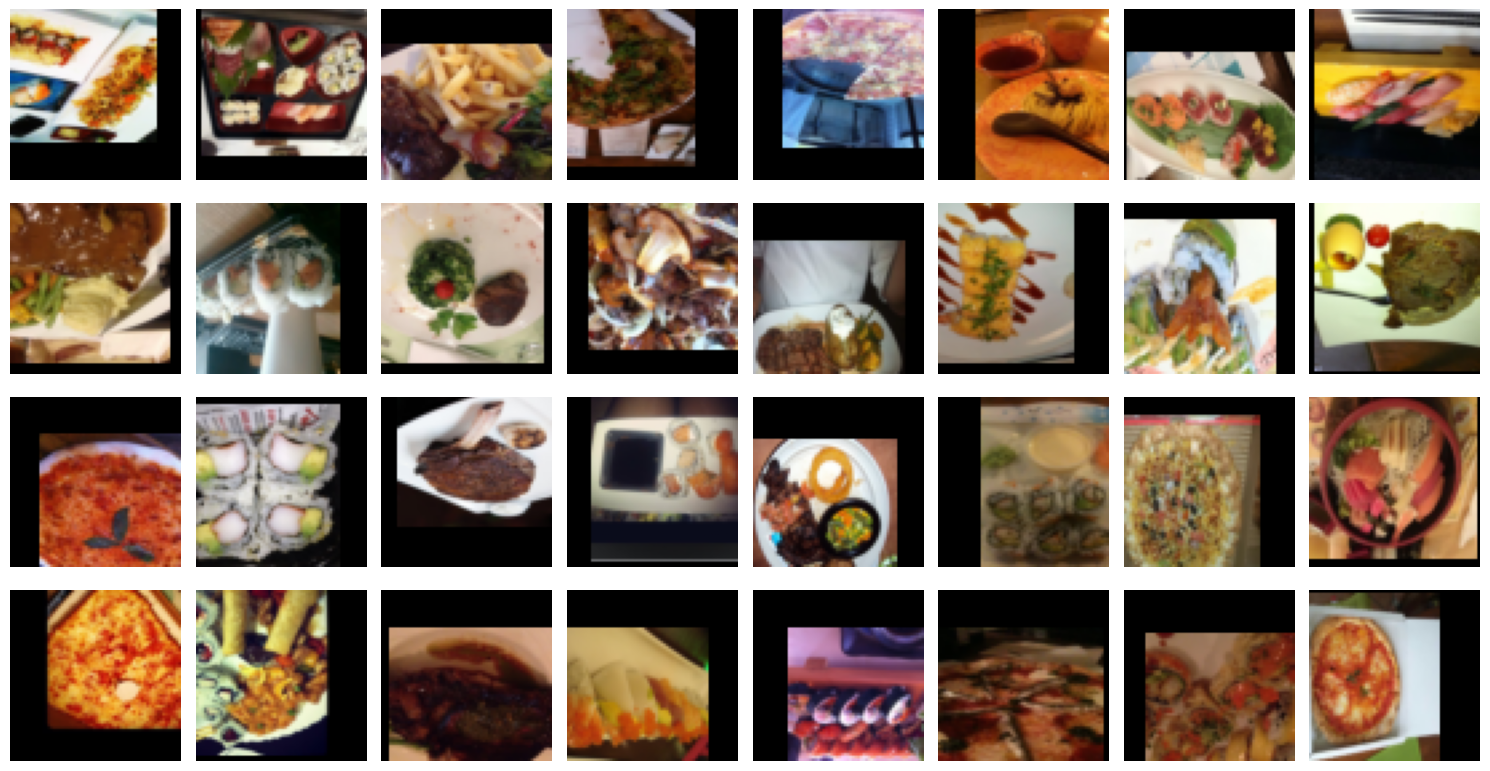

In [152]:
def imshow_grid(tensor):
    # tensor의 shape 가져오기
    n_imgs, c, h, w = tensor.shape
    
    # 4x8 그리드로 표시
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 8))

    for i, ax in enumerate(axes.flat):
        # i번째 이미지 tensor를 numpy 배열로 변환
        img = tensor[i].numpy().transpose((1, 2, 0))

        # [0, 1] 범위로 클리핑
        img = np.clip(img, 0, 1)

        # 이미지 표시
        ax.imshow(img)
        ax.axis("off")  # 축 정보 제거

    plt.tight_layout()
    plt.show()


# 이미지 그리드로 표시
imshow_grid(features)


In [ ]:
import tqdm

## CNN Model

In [39]:
# Create a convolutional neural network
class CNNModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, # in_features = (batch(=32), hidden_units*16*16)
                        out_features=hidden_units*16*16),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*16*16, # in_features = (batch(=32), hidden_units*16*16)
                        out_features=output_shape) # output_shape = len(target)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [40]:
cnn_model_augmented = CNNModelV2(input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)

cnn_model_augmented

CNNModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=2560, out_features=2560, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## Training

In [41]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(),
                            lr=0.1)

In [42]:
torch.manual_seed(SEED)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader_augmented,
        model=cnn_model_augmented,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cnn_model_augmented,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_cnn_model_augmented = print_train_time(start=train_time_start_model_2,
                                                end=train_time_end_model_2,
                                                device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.10050 | Train accuracy: 29.30%
Test loss: 1.10500 | Test accuracy: 19.79%

Epoch: 1
---------
Train loss: 1.09940 | Train accuracy: 28.91%
Test loss: 1.10565 | Test accuracy: 19.79%

Epoch: 2
---------
Train loss: 1.09967 | Train accuracy: 29.30%
Test loss: 1.10562 | Test accuracy: 19.79%

Train time on cpu: 76.973 seconds


## Evaluate trained Model

In [43]:
# Get cnn_model results
cnn_model_results_augmented = eval_model(
    model=cnn_model_augmented,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

cnn_model_results_augmented

{'model_name': 'CNNModelV2',
 'model_loss': 1.1059927940368652,
 'model_acc': 19.791666666666668}

# Compare model results

In [44]:
import pandas as pd

compare_results = pd.DataFrame([cnn_model_results, cnn_model_results_augmented])
compare_results

,model_name,model_loss,model_acc
0,CNNModelV1,1.155463,26.041667
1,CNNModelV2,1.105993,19.791667


In [ ]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_cnn_model,
                                    total_train_time_cnn_model_augmented]
compare_results

,model_name,model_loss,model_acc,training_time
0,CNNModelV1,1.162212,26.041667,6.631362
1,CNNModelV2,1.097609,44.507576,7.225784


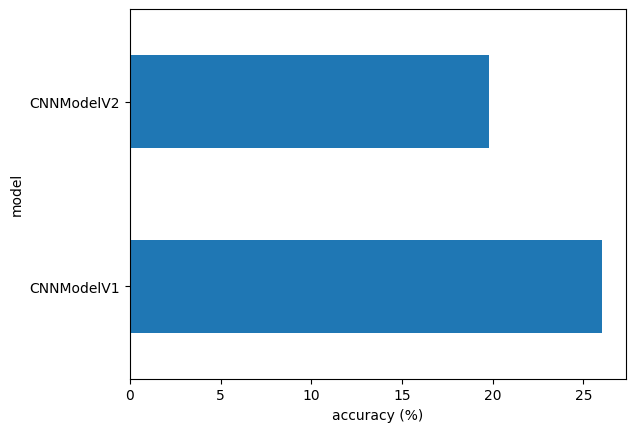

In [45]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");